# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

from sklearn.cluster import KMeans
from classes.binomial import BinomialExperiment #My own class for evaluating binomial split tests

import matplotlib.pyplot as plt

# read in the json files
offers = pd.read_json('data/portfolio.json', orient='records', lines=True)
users = pd.read_json('data/profile.json', orient='records', lines=True)
transactions = pd.read_json('data/transcript.json', orient='records', lines=True)

# Business Question

Which demographic segment is most likely to respond to an offer *the first time they receive it*? Which offer is best for each demo segment?

Implication of the answer is potentially minimized wasted coverage. Want to minimize contacts required to realize the offer.

**Planned Approach:** Machine learning approach. Cluster user by demo variables. Find out how likely each cluster is to complete each offer.

# Step 1: Basic Exploration

**Objectives**
1. Understand data types and which need changing
2. Look for columns I definitely won't need
3. Identify columns that will need to be transformed to be useful

In [2]:
# Create copies of all dataframes for exploration phase
users_ex = users.copy()
offers_ex = offers.copy()
transactions_ex = transactions.copy()

## Step 1a: Offers

In [3]:
offers_ex

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
offers_ex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


**Offers Verdict:**
1. Channels will need to be transformed. One-hot for user similarity? Dummy for prediction?
2. Check for NaNs

## Step 1b: Users

In [5]:
users_ex.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
users_ex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
users_ex.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [8]:
#cut income into discrete segments
#fill nan in users with 0. Because min income is 30k, I can create a bin from 0-30k can call that bin "unknown" to handle nans.
#choosing income bins based on presumed lifestyle and bin size (at least few thousand obs per bin is the goal)
users_ex['income'].fillna(0, inplace = True)
users_ex['income_group'] = pd.cut(users_ex['income'], bins = [0,30000,50000,80000,200000], labels = ['Unknown','Under 50k','50k - 80k','Over 80k'], include_lowest = True)

In [9]:
users_ex.head()

,gender,age,id,became_member_on,income,income_group
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0.0,Unknown
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,Over 80k
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,0.0,Unknown
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,Over 80k
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,0.0,Unknown


In [10]:
users_ex.loc[users_ex['gender'].isnull(), 'gender'] = 'Unknown'

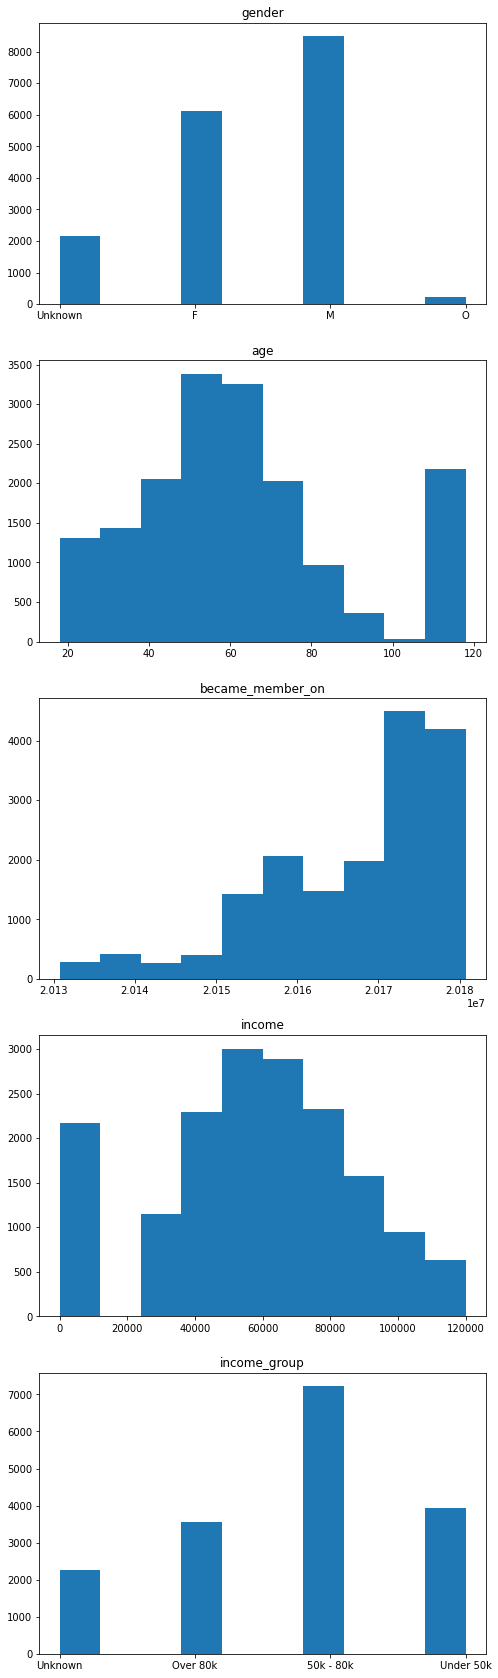

In [11]:
%matplotlib inline # will switch between inline and new window in this notebook, so easier to manage at cell level

#Check distributions of each user variable to see if any segments are overweighted.
def contrast_var_distributions(df, test_vars, segment_var = None):
    """
    Plots a series of histograms to contrast distributions of variables of interest.
    
    If a segment_var is provided, segments will be plotted in each figure to see how segments differ.
    """
    test_vars = test_vars
    n_test = len(test_vars)
    n_seg = len(df[segment_var].unique()) if segment_var else 1
    
    fig, ax = plt.subplots(n_test,n_seg,figsize = (8*n_seg,6*n_test))
    for i, col in enumerate(test_vars):
        if segment_var:
            # Get a color mapper object to allow me to color segments differently
            # Will also scale with added/removed segments
            cmap = plt.cm.get_cmap('hsv', n_seg)
            for k, seg in enumerate(df[segment_var].unique()):
                ax[i,k].hist(
                    df[col][df[segment_var] == seg], 
                    alpha = 0.5, 
                    label = seg, 
                    color = cmap(i), 
                    edgecolor = 'black'
                )
                ax[i,k].title.set_text(col + ', Segment ' + str(seg))
                ax[i,k].legend()
        else:
            ax[i].hist(df[col])
            ax[i].title.set_text(col)
    
contrast_var_distributions(users_ex, 
                           ['gender','age','became_member_on','income','income_group'], 
                           None)

In [12]:
#Quanitify O gender as percentage of dataset to formalize their potential impact on results
O_gender_percent = round((users_ex.gender == 'O').mean() * 100,2)
O_gender_count = (users_ex.gender == 'O').sum()

print('{} users have "O" gender. {}% of dataset.'.format(O_gender_count, O_gender_percent))

212 users have "O" gender. 1.25% of dataset.


**Users Verdict:** 
1. Convert became_member_on to date.
2. Assess the impact of NaN in income. Safe to remove them? Useful to remove them?
3. Assess the connections among None gender, 118 age and NaN income (are they a segment who don't receive/respond to offers?)
4. None gender should be converted to Unknown, because NoneType can't be analyzed, easily.
5. Drop became_member_on. Not enough variability for segmentation. Heavily weighted toward new users.
6. Other demo variables are useful. Distributed pretty widely around a mean.
7. NOTE: Customer base is, overall, relatively old. Mean of around 60, tapering off to both sides from there.
8. Don't know what "O" gender is. Drop them from the dataset. As 1.2% of our dataset, they are too small to model.

## Step 1c: Transactions

In [13]:
transactions_ex.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [14]:
transactions_ex.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [15]:
transactions_ex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


**Transactions Verdict:**
1. Need to do something with value. It's too complex. Offer ID useful for offer-type events. Otherwise amoung for transactions.
2. May need to convert time to days from hours since start of test. Would be easier to align it with offers frame.

# Step 2: Determine What to do with NaN

## Step 2a: Offers

No NaNs in the set. This one's utility is as a dimension table for offer id, anyway.

In [16]:
(offers_ex.isnull()).sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [17]:
offers_ex

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## Step 2b: Users

I already know from step 1 that gender and age contain strange values (None gender and many 188 ages). These look like code for "data not available." Should treat them like NaN. Find out what it means when a user doesn't have those metadata.

In [18]:
(users_ex.isnull()).sum()/users_ex.shape[0] * 100

gender              0.0
age                 0.0
id                  0.0
became_member_on    0.0
income              0.0
income_group        0.0
dtype: float64

In [19]:
# Check for coincidences among gender, age and income columns (looking for counts of what I think are null values)
print('{} users have NaN for income'.format(users_ex.income.isnull().sum()))
print('{} users have 118 for age'.format((users_ex.age == 118).sum()))
print('{} users have Unknown for gender'.format((users_ex.gender == 'Unknown').sum()))
(users_ex.isnull()).sum()

0 users have NaN for income
2175 users have 118 for age
2175 users have Unknown for gender


gender              0
age                 0
id                  0
became_member_on    0
income              0
income_group        0
dtype: int64

In [20]:
# Check to see if age 118 can be found in users other than NaN income and unknown gender
users_age_118 = users_ex.loc[users['age'] == 118]
print('Income values when age is 118: {}'.format(users_age_118.income.unique()))
print('Gender values when age is 118: {}'.format(users_age_118.gender.unique()))

Income values when age is 118: [0.]
Gender values when age is 118: ['Unknown']


In [21]:
# Check to make sure user IDs aren't duplicated, just to be safe
users_ex.id.duplicated().sum()

0

**Check to see if null users and non-null users could be different user segments**

In [22]:
# See if that null user segment means anything in the transactions dataframe
null_users = users_ex['id'][users_ex['age'] == 118].values
null_users_transactions = transactions_ex.loc[transactions_ex['person'].isin(null_users)]
nonnull_users_transactions = transactions_ex.loc[~transactions_ex['person'].isin(null_users)]

In [23]:
x_null = null_users_transactions.event.values
y_null = null_users_transactions.time.values
x = nonnull_users_transactions.event.values
y = nonnull_users_transactions.time.values

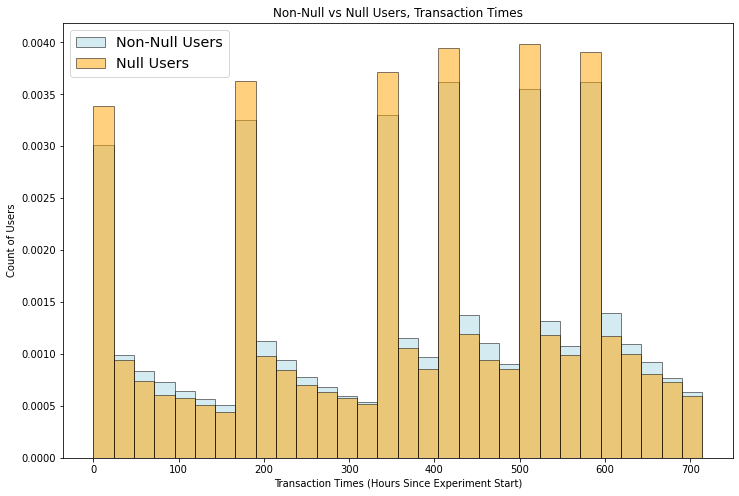

In [24]:
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(12,8));
ax.hist(y, bins = 30, color = 'lightblue', edgecolor = 'black', density = True, alpha = 0.5, label = 'Non-Null Users');
ax.hist(y_null, bins = 30, color = 'orange', edgecolor = 'black', density = True, alpha = 0.5, label = 'Null Users');
ax.title.set_text('Non-Null vs Null Users, Transaction Times');
ax.set_xlabel('Transaction Times (Hours Since Experiment Start)');
ax.set_ylabel('Count of Users');
ax.legend(fontsize = 'x-large');

**Verdict, Time comparison:** Null and non-null users are very similar in terms of their transaction timing after the experiment began. The pattern (several head/long-tail patterns) suggests promotion timing and seemingly that the promotions have some kind of positive effect on likelihood to purchase.

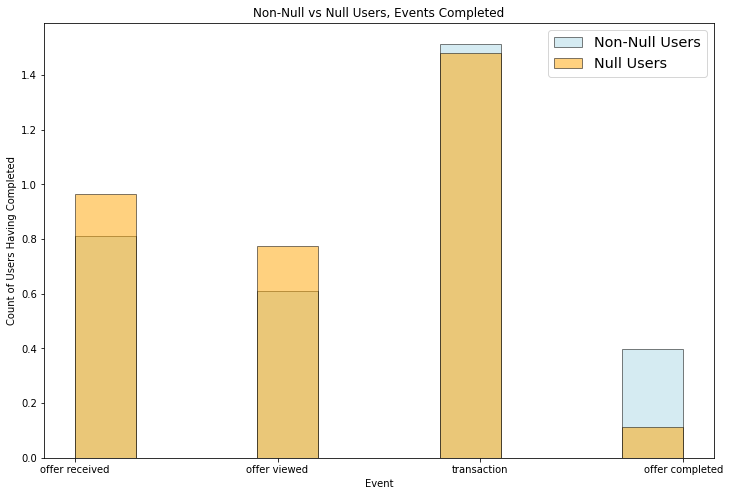

In [25]:
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize = (12,8));
ax.hist(x, color = 'lightblue', edgecolor = 'black', density = True, alpha = 0.5, label = 'Non-Null Users');
ax.hist(x_null, color = 'orange', edgecolor = 'black', density = True, alpha = 0.5, label = 'Null Users');
ax.title.set_text('Non-Null vs Null Users, Events Completed');
ax.set_xlabel('Event');
ax.set_ylabel('Count of Users Having Completed');
ax.legend(fontsize = 'x-large');

**Verdict, Events comparison:** There is a difference between null and non-null users in terms of the events they tended to complete during the experiment. Non-null users seem more likely to complete an offer relative to their likelihoods to receive and view offers.

Perhaps a user who doesn't provide age, gender and income isn't invested enough in Starbucks to work toward the completion of an offer.

**Verdict**
1. 13% of income values are null. 13% of users have not given Starbucks an indication of their income
2. Gender unknown, age 118 and income NaN all coincide 100%. That's a user segment.
3. User segment event histories and transaction timings are mostly the same. Null segment less likely to complete offers.
4. **Decision:** Keep them and treat them like a user segment in modeling. Turn income into a categorical var (cut it).

## Step 2c: Transactions

No obvious NaNs in the whole set.

In [26]:
(transactions_ex.isnull()).sum()

person    0
event     0
value     0
time      0
dtype: int64

In [27]:
transactions_ex.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [28]:
# Check to see what "value" looks like for each "event" type
for e in transactions_ex.event.unique():
    print(transactions_ex.loc[transactions_ex.event == e, ['event','value']].head(1).values)

[['offer received' {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}]]
[['offer viewed' {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}]]
[['transaction' {'amount': 0.8300000000000001}]]
[['offer completed'
  {'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}]]


**Verdict:** No NaNs. Value column is complex, though. Will need to reason out how to handle that one.

## Step 3: Clean Datasets
1. Users needs to be a dataset full of categorical segments (clustering)
2. Offers needs no cleaning
3. Transactions needs to show users who viewed offers and whether or not they completed the viewed offers

### Step 3a: Users

1. Income fillna(0) to allow for a cut of "unknown" for 0-30k income
2. Cut income into segments (0-30k, 30-50k, 50-80k, over 80k)
3. Cut age into segments (under 40, 40-60, 60-80, over 80)
4. Replace NaN codes with "unknown" to give it a categorical level in those variables
5. Remove became_member_on. Not enough variability in that field to create meaningful segments (2014 and 2015 only have 1000 users each, meanwhile tons of users in 2018)
6. Remove income (continuous version)
7. Remove age (continuous version)

**Output:** users_clean, on which we can perform exploratory analyses. users_dummies, which will be the input array for clustering.

In [29]:
# Define functions to clean and transform dataframes
def clean_users(users_df):
    """
    Takes the user dataframe and cleans it according to the steps determined during exploration.
    1. Income fillna(0) to allow for a cut of "unknown" for 0-30k income
    2. Cut income into segments (0-30k, 30-50k, 50-80k, over 80k)
    3. Replace NaN codes in remainding variables with "unknown" to give it a categorical level in those variables
    4. Cut age into segments (under 40, 40-60, 60-80, over 80)
    5. Remove became_member_on.
    6. Remove income (continuous version).
    """
    # Fill income NaN with 0
    users_df.income.fillna(0, inplace = True)
    
    # Cut income into segments
    users_df['income_segment'] = pd.cut(users_df.income, 
                                        bins = [0,30000,50000,80000,200000], 
                                        labels = ['Unknown','Under 50k','50k-80k','Over 80k'], 
                                        include_lowest = True)
    
    # Cut age into segments
    users_df['age_segment'] = pd.cut(users_df.age,
                                    bins = [0,24,40,60,80,117,200],
                                    labels = ['24 and Under','25-40','41-60','61-80','81 and Over','Unknown'],
                                    include_lowest = False)
    
    # Replace NaN codes in gender with "unknown" and drop gender "O"
    users_df.loc[users_df['gender'].isnull(), 'gender'] = 'Unknown'
    users_df = users_df.loc[users_df['gender'] != 'O']
    
    # Drop income, became_member_on and age columns
    clean_users = users_df.drop(columns = ['income','age','became_member_on'])
    
    return clean_users

In [30]:
#create cleaned version of users, in case I want to explore or debug, later
users_clean = clean_users(users)

In [31]:
users_clean.head()

,gender,id,income_segment,age_segment
0,Unknown,68be06ca386d4c31939f3a4f0e3dd783,Unknown,Unknown
1,F,0610b486422d4921ae7d2bf64640c50b,Over 80k,41-60
2,Unknown,38fe809add3b4fcf9315a9694bb96ff5,Unknown,Unknown
3,F,78afa995795e4d85b5d9ceeca43f5fef,Over 80k,61-80
4,Unknown,a03223e636434f42ac4c3df47e8bac43,Unknown,Unknown


In [32]:
#Dummy encode the users frame to create our input array for clustering.
#Use dummy (not one-hot) to avoid correlation among dummy variables and improve clustering.
users_dummies = pd.get_dummies(users_clean, columns = ['gender','income_segment','age_segment'], drop_first = True)

In [33]:
users_dummies.head()

,id,gender_M,gender_Unknown,income_segment_Under 50k,income_segment_50k-80k,income_segment_Over 80k,age_segment_25-40,age_segment_41-60,age_segment_61-80,age_segment_81 and Over,age_segment_Unknown
0,68be06ca386d4c31939f3a4f0e3dd783,0,1,0,0,0,0,0,0,0,1
1,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,1,0,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,0,1,0,0,0,0,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,1,0,0,1,0,0
4,a03223e636434f42ac4c3df47e8bac43,0,1,0,0,0,0,0,0,0,1


### Step 3b: Transactions

**Objective**: Turn this into a multi-outcome array, then break the outcome variables by the clusters generated during the cluster analysis of the users frame. Find out if cluster representation changes by outcome.

**Tasks**:
1. Need offer received, viewed and completed (offer duration starts at receipt, not view)
2. Create an offer_id variable from value and then drop value
3. Deduplicate frame fo person, event and offer id. Person can receive or complete offer more than once. Take earliest of both events to answer the business question. If earliest complete date < earliest offer date, offer wasn't necessary to inspire completion. If vice versa, inference of attribution is valid enough to be useful.
3. Filter offer_id so that, for each person, IDs are only included when complete doesn't come before viewed

In [34]:
offers

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [57]:
def clean_transactions(trans_df, offer_df, users_df):
    """
    Takes the transactions dataframe and cleans it. Turns it into a multi-outcome array that plays
    nicely with the results of a cluster analysis performed on the users dataframe.
    
    Ultimate goal is seeing if cluster representation changes for each offer ID.
    
    Final frame represents initial response rates to each offer (first receipt). Once we cluster the users dataframe,
    we can merge it with this frame and then show response rates by cluster for each offer. 1 means the user completed the
    offer within the offer's duration (from the time of receipt).
    
    One step further, we can also merge offers to get offer type. 
    Then break down response rates by cluster for each offer type.
    """
    # Filter df for important events, only (events with event ID attached, bc all we care about is response or non-response)
    sig_events = ['offer received', 'offer viewed', 'offer completed']
    filtered_df = trans_df.loc[trans_df['event'].isin(sig_events)].reset_index(drop = True).copy()
    
    # Create offer_id variable from value
    # NOTE: value is a series of dict. Offer ID key when event is viewed is "offer id." It's "offer_id" when event is completed.
    filtered_df['offer_id'] = filtered_df['value'].apply(
        lambda x: x['offer_id'] if 'offer_id' in x.keys() else x['offer id']
    )
    filtered_df.drop(columns = ['value'], 
                     inplace = True)
    
    # Deduplicate the dataframe for person, event and offer_id. Take min(time) for each.
    deduped_df = filtered_df.groupby(['person','event','offer_id'], 
                                     as_index = False)['time'].agg(np.min)
    
    # Pivot out event with time as the values to see when each person received and completed each offer
    # Resetting index leaves person and offer_id as columns rather than creating a mult-index from them
    # Will make merging easier, later
    pivoted_df = deduped_df.pivot(index = ['person','offer_id'], 
                                  columns = ['event'], 
                                  values = 'time').reset_index(drop = False)
    
    # Filter pivoted_df so that we're only working with valid test cases for response rates
    # Must be a viewed time.
    # Completed time can't be less than viewed time (greater than and NaN both okay)
    # Days between view and receipt must <= the offer term in days
    filtered_pivot = pivoted_df.loc[
        (~pivoted_df['offer viewed'].isnull()) & 
        (~(pivoted_df['offer completed'] < pivoted_df['offer viewed']))
    ]
    filtered_pivot = filtered_pivot.merge(
        offer_df[['id','duration','offer_type']], 
        how = 'left', 
        left_on = 'offer_id', 
        right_on = 'id'
    ).drop(columns = 'id')
    # Convert offer viewed and offer completed (hours) to days
    filtered_pivot[['offer received','offer viewed','offer completed']] = filtered_pivot[['offer received','offer viewed', 'offer completed']] / 24
    
    # Add a column for response, 1 if completion happened in offer window. Else 0.
    filtered_pivot['offer_response'] = filtered_pivot.apply(
        lambda x: 1 if x['offer completed'] - x['offer received'] <= x['duration'] else 0, 
        axis = 1
    )
    
    # filter the final product for only person that appears in users_clean
    filtered_pivot = filtered_pivot.loc[filtered_pivot['person'].isin(users_df['id'].unique())].reset_index(drop = True).copy()
    
    return filtered_pivot[['person','offer_id','offer_type','offer_response']]

In [36]:
clean_transactions(transactions, offers, users_clean).head()

,person,offer_id,offer_type,offer_response
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,0
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,bogo,0
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,informational,0


In [37]:
transactions_clean = clean_transactions(transactions, offers, users_clean)
transactions_clean.head()

,person,offer_id,offer_type,offer_response
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,0
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,bogo,0
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,informational,0


## Step 4: Cluster the Users DataFrame

- Trying K Means
- First, figure out how many clusters (k = ?)
- Then, generate clusters
- Step 5 will be analyzing transactions_clean by cluster

In [38]:
# Step 1: Get an X array from the users dataframe
users_dummies.head()

,id,gender_M,gender_Unknown,income_segment_Under 50k,income_segment_50k-80k,income_segment_Over 80k,age_segment_25-40,age_segment_41-60,age_segment_61-80,age_segment_81 and Over,age_segment_Unknown
0,68be06ca386d4c31939f3a4f0e3dd783,0,1,0,0,0,0,0,0,0,1
1,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,1,0,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,0,1,0,0,0,0,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,1,0,0,1,0,0
4,a03223e636434f42ac4c3df47e8bac43,0,1,0,0,0,0,0,0,0,1


In [39]:
X_users = np.array(users_dummies.drop(columns = 'id'))

In [40]:
# Step 2: determine optimial number of centroids using within-cluster sum of squares
wcss = []
for i in range(20):
    kmeans = KMeans(i+1)
    kmeans.fit(X_users)
    wcss.append(kmeans.inertia_)

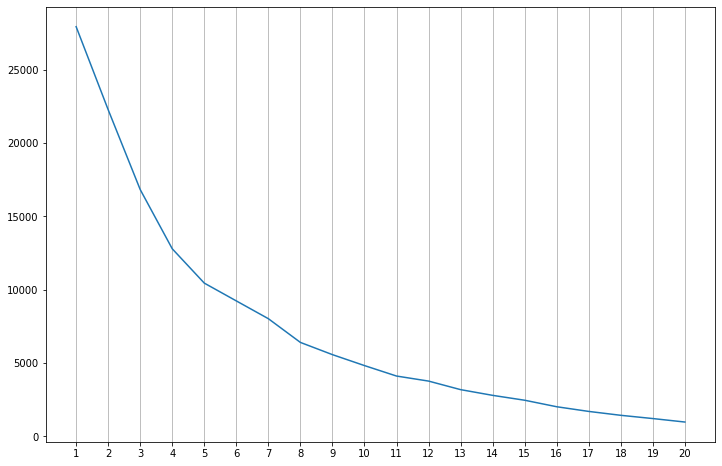

In [75]:
%matplotlib inline
# Plot wcss for each centroid count
fig, ax = plt.subplots(1,1,figsize = (12,8));
ax.plot([i+1 for i in range(20)], wcss);
ax.set_xticks([i+1 for i in range(20)]);
ax.grid(b = True, axis = 'x')

**Verdict**: Clustering seems to be optimized with 5 or 6 centroids. Let's go with 6 to minimize ambiguity among segments and hopefully get clearer response rate differentials.

In [59]:
# Step 3: Cluster users using 6 centroids and KMeans
user_kmeans = KMeans(8, random_state = 1)
labels = user_kmeans.fit_predict(X_users)

In [60]:
# Step 4: Add clusters to users_clean
users_clean['cluster'] = labels

In [61]:
users_clean.head()

,gender,id,income_segment,age_segment,cluster
0,Unknown,68be06ca386d4c31939f3a4f0e3dd783,Unknown,Unknown,2
1,F,0610b486422d4921ae7d2bf64640c50b,Over 80k,41-60,1
2,Unknown,38fe809add3b4fcf9315a9694bb96ff5,Unknown,Unknown,2
3,F,78afa995795e4d85b5d9ceeca43f5fef,Over 80k,61-80,4
4,Unknown,a03223e636434f42ac4c3df47e8bac43,Unknown,Unknown,2


In [62]:
# Check to see if any segments are too small to be useful
fig_cluster, ax_cluster = plt.subplots(1,1)
ax_cluster.hist(users_clean.cluster, align = 'left');
ax_cluster.set_xticks(list(range(len(users_clean.cluster.unique()))));

In [63]:
# Open this grid of histograms in an interactive window. Too small to understand, when inline.
%matplotlib qt
contrast_var_distributions(users_clean, ['gender','income_segment','age_segment'], 'cluster')

**Interpretation of Clusters:**

In general:
- Gender is not a determining factor in cluster assignment
- Income was a prominent differentiator among users (1 unknown, 2 high, 1 low, 2 middle segments)
- Age was the secondary differentiator
- So, our segments are mostly income/age-based

Cluster-specific:

- Lowest Income (under 50k). All Ages.
- Middle-income (51-80k). Late career (41-60 age).
- Middle-income. Retired age (61-80 age).
- Middle-income. Early-mid career (under 40).
- High-income. Late-career and retirement age (41-60 and 61-80 and 80+).
- The unknowns. Users who do not provide demo data.

## Step 5: Analyze Response Rates by Cluster

In [64]:
# Merge cluster labels with transactions_clean
responses = transactions_clean.merge(users_clean[['id','cluster']], how = 'left', left_on = 'person', right_on = 'id').drop(columns = 'id')
responses.head()

,person,offer_id,offer_type,offer_response,cluster
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,0,5
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,0,5
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,bogo,0,2
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1,1
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,informational,0,1


### Step 5a: Check Response Rates to Find best Promotion for Each User Cluster

In [65]:
# Check response rates for each discount type
response_rates = responses.groupby(
    ['cluster','offer_type'], 
    as_index = False
)['offer_response'].agg({'offer_response':'mean'}).round(2).pivot(
    index = 'cluster', 
    columns = 'offer_type', 
    values = 'offer_response')

response_rates

offer_type,bogo,discount,informational
cluster,,,
0,0.58,0.73,0.0
1,0.70,0.77,0.0
2,0.09,0.22,0.0
3,0.35,0.64,0.0
4,0.72,0.81,0.0
5,0.49,0.70,0.0
6,0.35,0.59,0.0
7,0.57,0.70,0.0


In [66]:
# Create a new version of response_rates so that only bogo and discount are compared (no responses for information by design)
response_tests = response_rates[['bogo','discount']]
response_tests

offer_type,bogo,discount
cluster,,
0,0.58,0.73
1,0.70,0.77
2,0.09,0.22
3,0.35,0.64
4,0.72,0.81
5,0.49,0.70
6,0.35,0.59
7,0.57,0.70


### Step 5b: Check Significance of Cluster Contrasts

- Method: Assess 95% confidence intervals for "control" (bogo) and "treatment" (discount) for overlap. If no overlap, conclude difference is statistically non-zero.
- Using the imported custom class "BinomialExperiment" to run the assessemnt. Can be found in "classes" folder of github repo.

In [67]:
# Check each cluster's set of response rates for statistical significance
figs = dict()
for idx in response_tests.index:
    p_control = response_tests.loc[idx, 'bogo']
    p_treatment = response_tests.loc[idx, 'discount']
    
    n_control = len(responses[(responses.offer_type == 'bogo') & (responses.cluster == idx)])
    n_treatment = len(responses[(responses.offer_type == 'discount') & (responses.cluster == idx)])
    
    figs[idx] = BinomialExperiment(p_control = p_control, p_treatment = p_treatment, n_control = n_control, n_treatment = n_treatment).plot_confidence()

In [68]:
figs[0]

#### Cluster 0: Mid-Income. Mid- and Early-Career
- Definitely a significant difference between response rates to discount vs BOGO.
- BOGO response rate is approx 50%.
- Discount response rate is approx 70%.

**Verdict:** SBUX should target these users with discount to maximize response rate.

In [69]:
figs[1]

#### Cluster 1: The Unknowns
- Definitely a significant difference between response rates to discount vs BOGO.
- BOGO response rate is approx 8%.
- Discount response rate is approx 23%.

**Verdict:** SBUX should not target users with either promotion. They are unlikely to respond to either.

In [70]:
figs[2]

#### Cluster 2: Low-Income. All Ages.
- Definitely a significant difference between response rates to discount vs BOGO.
- BOGO response rate is approx 37%.
- Discount response rate is approx 63%.

**Verdict:** SBUX should target these users with discount to maximize response rate.

In [71]:
figs[3]

#### Cluster 3: High Income. Over 41 years old (late career and retired).
- Definitely a significant difference between response rates to discount vs BOGO.
- BOGO response rate is approx 72%.
- Discount response rate is approx 79%.

**Verdict:** SBUX should target these users with discount to maximize response rate, but BOGO is also an option. Next step could be breaking this segment down to understand if subsegments respond differently.

In [72]:
figs[4]

#### Cluster 4: Mid-income. Late career.
- Definitely a significant difference between response rates to discount vs BOGO.
- BOGO response rate is approx 57%.
- Discount response rate is approx 74%.

**Verdict:** SBUX should target these users with discount to maximize response rate.

In [73]:
figs[5]

#### Cluster 5: Mid-income. Retired age.
- Definitely a significant difference between response rates to discount vs BOGO.
- BOGO response rate is approx 57%.
- Discount response rate is approx 71%.

**Verdict:** SBUX should target these users with discount to maximize response rate.

**OVERAL VERDICT: SEGMENT RESPONSE RATES**
- Almost every segment responds far better to **discount** than to BOGO.
- **EXCEPTION:** The "unknowns." They don't respond well to either. SBUX should wait until their involvement levels deepen before targeting them.
- **EXCEPTION:** High-Income, Late-Career + Retired. Older users of high income respond at very high rates to both the BOGO and Discount offers. Discount performs a little better, so that one should be prioritized, with them.
- Gender really has nothing material to do with response rates (unless it wasn't provided).